In [34]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Network Science Analytics
Lab 1: Centrality Criteria 
3 February 2023
"""
from helper import *
import numpy as np
import scipy.sparse as sparse
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import networkx as nx

### Part I: Analysis of a real-world network

#### Exercise 1: Basic properties of the network

In [35]:
# 1.1) Read the edgelist of the NetScience network
G = nx.read_edgelist("NetScience.edgelist", comments='#', delimiter='\t')

In [36]:
# 1.2) Compute various characteristics of the network
def compute_network_characteristics(graph):
    prop = {}
    prop['N'] = graph.number_of_nodes() # number of nodes
    prop['M'] = graph.number_of_edges() # number of edges
    # degrees = list(dict(G.degree()).values())
    degrees = [degree for node, degree in graph.degree()] # degree list
    prop['min_degree'] = np.min(degrees) # minimum degree
    prop['max_degree'] = np.max(degrees) # maximum degree
    prop['mean_degree'] = np.mean(degrees) # mean of node degrees
    prop['median_degree'] = np.median(degrees) # median of node degrees
    prop['density'] = nx.density(graph) # density of the graph
    return prop

###################################################################
prop = compute_network_characteristics(graph=G)
print("Number of nodes: {}".format(prop['N']))
print("Number of edges: {}".format(prop['M']))
print("Min. degree: {}".format(prop['min_degree']))
print("Max. degree: {}".format(prop['max_degree']))
print("Mean degree: {}".format(prop['mean_degree']))
print("Median degree: {}".format(prop['median_degree']))
print("Density: {}".format(prop['density']))

Number of nodes: 1461
Number of edges: 2742
Min. degree: 1
Max. degree: 34
Mean degree: 3.753593429158111
Median degree: 3.0
Density: 0.0025709544035329526


#### Exercise 2: Connected components of the graph

In [37]:
def get_gcc(graph):
    # Is the given graph connected?
    connected = nx.is_connected(graph) # check if the graph is connected or not
    if connected:
        print("The graph is connected")
        return graph
    
    print("The graph is not connected")
    
    # Find the number of connected components
    num_of_cc = nx.number_connected_components(graph)
    print("Number of connected components: {}".format(num_of_cc))
    
    # Get the greatest connected component subgraph
    gcc_nodes = max(nx.connected_components(graph), key=len)
    gcc = graph.subgraph(gcc_nodes)
    node_fraction = gcc.number_of_nodes() / float(graph.number_of_nodes())
    edge_fraction = gcc.number_of_edges() / float(graph.number_of_edges())
    
    print("Fraction of nodes in GCC: {:.3f}".format(node_fraction))
    print("Fraction of edges in GCC: {:.3f}".format(edge_fraction))

    return gcc

# Get the GGC of the network
gcc = get_gcc(graph=G)

The graph is not connected
Number of connected components: 268
Fraction of nodes in GCC: 0.259
Fraction of edges in GCC: 0.333


### Part II: Centrality Measures

In [38]:
# Read the edgelist of the NetScience network
G0 = nx.read_edgelist("./NetScience.edgelist", comments='#', delimiter='\t')
# Get the largest connected component of the network
nodes = max(nx.connected_components(G0), key=len) 
G = G0.subgraph(nodes)

#### Exercise 3: Implementation of Centrality Measures and Visualization of the Network

In [39]:
# 1.1) Degree Centrality
def compute_degree_centrality(graph):
    '''
    :param graph:
    :return:
        degree_centrality:
        Dictionary of nodes with degree centrality as the value
    '''
    degree_centrality = {}
    ### Please write your code below
    m = np.mean([degree for _, degree in nx.degree(G)]) 
    for node in graph.nodes():
        degree_centrality[node] = graph.degree(node) / m
    
    ###
    return degree_centrality

In [40]:
## 1.2) Closeness Centrality
def compute_closeness_centrality(graph):
    '''
    :param graph:
    :return:
        closeness_centrality:
        Dictionary of nodes with closeness centrality as the value
    '''
    closeness_centrality = {}
    ### Please write your code below
    N = graph.number_of_nodes()
    for node in graph.nodes():
        path_lens = nx.single_source_shortest_path_length(graph, node)
        path_len_sum = sum(path_lens.values())
        closeness_centrality[node] = float(N-1) / path_len_sum

    ###
    return closeness_centrality

# Check if the implementation returns corrrect values
assert nx.closeness_centrality(G).items() == compute_closeness_centrality(G).items()

In [41]:
# 1.3) Harmonic Centrality
def compute_harmonic_centrality(graph):
    '''
    :param graph:
    :return:
        harmonic_centrality:
        Dictionary of nodes with harmonic centrality as the value
    '''
    harmonic_centrality = {}
    ### Please write your code below

    for node in graph.nodes():
        path_lens = nx.single_source_shortest_path_length(graph, node)
        harmonic_centrality[node] = sum([1.0/value for value in path_lens.values() if value>0])

    ###
    return harmonic_centrality

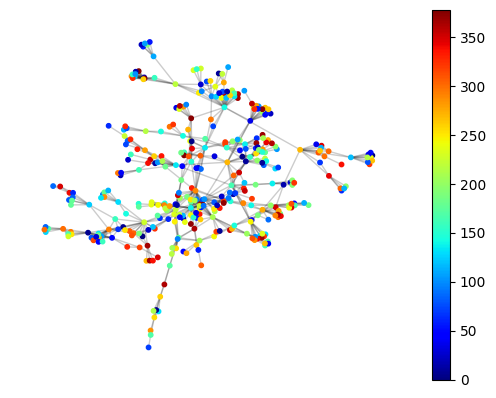

In [42]:
# 1.4) Visualization
# Example code for visualization
node2values = assign_random_values(graph=G)
visualize(graph=G, values=node2values, node_size=10)

In [43]:
# 1.5) (Optional) Core Number
def compute_core_number(graph):
    '''
    :param graph:
    :return:
        core_number:
        Dictionary of nodes with core number as the value
    '''
    core_number = {}
    ### Please write your code below
    
    # Reformat node
    node2degree = dict(graph.degree)
    # Sort the nodes according to their degrees
    node_list = [n for _, n in sorted(zip(node2degree.values(), node2degree.keys()))]
    
    # Loop on each node 
    for i, node in enumerate(node_list):
        core_number[node] = node2degree[node]
        # Update neighbours degree and order in node list
        for nb in nx.neighbors(graph, node):
            if node2degree[nb] > node2degree[node]:
                node2degree[nb] -= 1
                # Reorder the node_list
                j = len(node_list)-1
                while j > i:
                    if node2degree[node_list[j]] == node2degree[nb]:
                        break
                    j -= 1
                while j > i:
                    if node2degree[node_list[j-1]] > node2degree[nb]:
                        node_list[j] = node_list[j-1]
                    else:
                        node_list[j] = nb
                        break
                    j -= 1
                    
    ###
    return core_number

# Check if the implementation returns corrrect values
assert compute_core_number(G).items() == nx.core_number(G).items()

In [44]:
# 1.6) (Optional) Neighborhood Coreness
def compute_neighborhood_coreness(graph):
    '''
    :param graph:
    :return:
        nb_coreness:
        Dictionary of nodes with core number as the value
    '''
    nb_coreness = {}
    ### Please write your code below

    core_number = compute_core_number(graph)
    for node in core_number:
        nb_coreness[node] = 0
        for nb in graph.neighbors(node):
            nb_coreness[node] += core_number[nb]

    ###
    return nb_coreness

#print(compute_neighborhood_coreness(G))

### Part III: Robustness of the Network

In [45]:
# Read the edgelist of the ca-GrQc network
G0 = nx.read_edgelist("./ca-GrQc.edgelist", comments='#', delimiter='\t')
# Get the largest connected component of the network
nodes = max(nx.connected_components(G0), key=len)
G = G0.subgraph(nodes)

#### Exercise 4: Analysis of the robustness

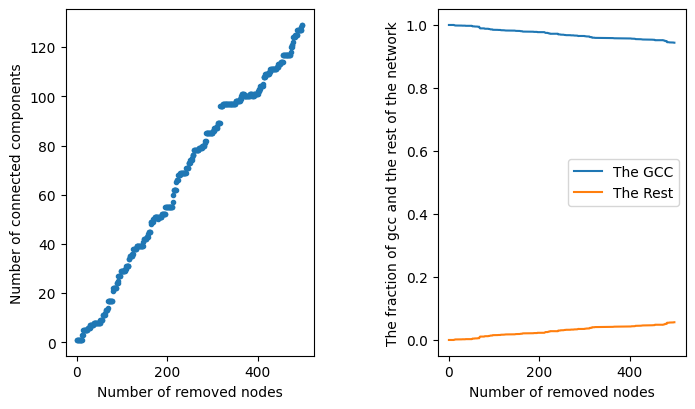

In [46]:
def plot_robustness_analysis(graph, node2values, k):
    '''
    :param graph:
    :param node2values: Dictionary of nodes with centrality values
    :param k: the number of nodes to be removed
    '''
    num_connected_components = []
    gcc_sizes = []
    rest_sizes = []
    # Please write your code below    
    
    # Copy the given graph in order to keep it from modifications
    g = graph.copy()
    # Generate a node list with respect to the values given 
    # in the node2values dictionary in descending order
    pairs = sorted(node2values.items(), key=lambda x: x[1], reverse=True)
    node_list = [p[0] for p in pairs]
    # Get the first k nodes
    node_remove_list = node_list[:k]
    
    for node in node_remove_list:
        g.remove_node(node) # remove a node
        num_connected_components.append(nx.number_connected_components(g))
        gcc = g.subgraph(max(nx.connected_components(g), key=len))
        r = gcc.number_of_nodes() / float(g.number_of_nodes())
        gcc_sizes.append(r)
        rest_sizes.append(1-r)
    
    ## Plot
    plt.figure(figsize=(8,4.5))
    plt.subplot(1, 2, 1)
    plt.plot(num_connected_components, '.')
    plt.xlabel("Number of removed nodes")
    plt.ylabel("Number of connected components")
    plt.subplot(1, 2, 2)
    line1, = plt.plot(gcc_sizes, label="The GCC") 
    line2, = plt.plot(rest_sizes, label="The Rest")
    plt.xlabel("Number of removed nodes")
    plt.ylabel("The fraction of gcc and the rest of the network")
    plt.legend(handles=[line1, line2])
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    
#  Choose a centrality measure, you can also use built-in functions
node2values = assign_random_values(graph=G)
k = 500 # k is the number of nodes to be removed
plot_robustness_analysis(G, node2values, k)